# Прогнозирование конечных свойств новых материалов (композиционных материалов)
Композиционные материалы - это искусственно созданные материалы, состоящие из нескольких других с четкой границей между ними. Композиты обладают теми свойствами, которые не наблюдаются у компонентов по отдельности. При этом композиты являются монолитным материалом, т. е. компоненты материала неотделимы друг от друга без разрушения конструкции в целом. Яркий пример композита - железобетон. Бетон прекрасно сопротивляется сжатию, но плохо растяжению. Стальная арматура внутри бетона компенсирует его неспособность сопротивляться сжатию, формируя тем самым новые, уникальные свойства. Современные композиты изготавливаются из других материалов: полимеры, керамика, стеклянные и углеродные волокна, но данный принцип сохраняется. У такого подхода есть и недостаток: даже если мы знаем характеристики исходных компонентов, определить характеристики композита, состоящего из этих компонентов, достаточно проблематично. Для решения этой проблемы есть два пути: физические испытания образцов материалов, или прогнозирование характеристик. Суть прогнозирования заключается в симуляции представительного элемента объема композита, на основе данных о характеристиках входящих компонентов (связующего и армирующего компонента)

## Требования
1. Изучить теоретические основы и методы решения поставленной задачи.
2. Провести разведочный анализ предложенных данных. Необходимо нарисовать гистограммы распределения каждой из переменной, диаграммы ящика с усами, попарные графики рассеяния точек. Необходимо также для каждой колонке получить среднее, медианное значение, провести анализ и исключение выбросов, проверить наличие пропусков.
3. Провести предобработку данных (удаление шумов, нормализация и т.д.).
4. Обучить нескольких моделей для прогноза модуля упругости при растяжении и прочности при растяжении. При построении модели необходимо 30% данных оставить на тестирование модели, на остальных происходит обучение моделей. При построении моделей провести поиск гиперпараметров модели с помощью поиска по сетке с перекрестной проверкой, количество блоков равно 10.
5. Написать нейронную сеть, которая будет рекомендовать соотношение матрица-наполнитель.
6. Разработать приложение с графическим интерфейсом или интерфейсом командной строки, которое будет выдавать прогноз, полученный в задании 4 или 5 (один или два прогноза, на выбор учащегося).
7. Оценить точность модели на тренировочном и тестовом датасете. 
8. Создать репозиторий в GitHub / GitLab и разместить там код исследования. Оформить файл README.

## Импорты

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import scipy.stats as stats
from joblib import dump, load

## Загрузить и объединить датасет

### Загрузка данных

In [2]:
X_bp = pd.read_excel(
    'https://github.com/ritulupov/BKP/blob/main/data/X_bp.xlsx?raw=true',
     index_col=0, engine='openpyxl')

X_nup = pd.read_excel(
    'https://github.com/ritulupov/BKP/blob/main/data/X_nup.xlsx?raw=true',
     index_col=0, engine='openpyxl')

In [3]:
X_bp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1023 entries, 0 to 1022
Data columns (total 10 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Соотношение матрица-наполнитель       1023 non-null   float64
 1   Плотность, кг/м3                      1023 non-null   float64
 2   модуль упругости, ГПа                 1023 non-null   float64
 3   Количество отвердителя, м.%           1023 non-null   float64
 4   Содержание эпоксидных групп,%_2       1023 non-null   float64
 5   Температура вспышки, С_2              1023 non-null   float64
 6   Поверхностная плотность, г/м2         1023 non-null   float64
 7   Модуль упругости при растяжении, ГПа  1023 non-null   float64
 8   Прочность при растяжении, МПа         1023 non-null   float64
 9   Потребление смолы, г/м2               1023 non-null   float64
dtypes: float64(10)
memory usage: 87.9 KB


Есть 10 колонок тип данных float64. Строк 1024, пропусков нет.

In [4]:
X_nup.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1040 entries, 0 to 1039
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Угол нашивки, град  1040 non-null   int64  
 1   Шаг нашивки         1040 non-null   float64
 2   Плотность нашивки   1040 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 32.5 KB


Есть 3 колонки. 1 - int, 2 - float64. Строк 1040, пропусков нет.

### Объединение по индексу тип объединения INNER

In [5]:
full_df = X_bp.join(X_nup)

In [6]:
full_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Соотношение матрица-наполнитель,1023.0,2.930366,0.913222,0.389403,2.317887,2.906878,3.552660,5.591742
"Плотность, кг/м3",1023.0,1975.734888,73.729231,1731.764635,1924.155467,1977.621657,2021.374375,2207.773481
"модуль упругости, ГПа",1023.0,739.923233,330.231581,2.436909,500.047452,739.664328,961.812526,1911.536477
"Количество отвердителя, м.%",1023.0,110.570769,28.295911,17.740275,92.443497,110.564840,129.730366,198.953207
"Содержание эпоксидных групп,%_2",1023.0,22.244390,2.406301,14.254985,20.608034,22.230744,23.961934,33.000000
"Температура вспышки, С_2",1023.0,285.882151,40.943260,100.000000,259.066528,285.896812,313.002106,413.273418
"Поверхностная плотность, г/м2",1023.0,482.731833,281.314690,0.603740,266.816645,451.864365,693.225017,1399.542362
"Модуль упругости при растяжении, ГПа",1023.0,73.328571,3.118983,64.054061,71.245018,73.268805,75.356612,82.682051
"Прочность при растяжении, МПа",1023.0,2466.922843,485.628006,1036.856605,2135.850448,2459.524526,2767.193119,3848.436732
"Потребление смолы, г/м2",1023.0,218.423144,59.735931,33.803026,179.627520,219.198882,257.481724,414.590628


In [7]:
drop_cols = ['Плотность, кг/м3',
             'модуль упругости, ГПа',
             'Поверхностная плотность, г/м2'
             ]
targ_cols = ['Модуль упругости при растяжении, ГПа',
             'Прочность при растяжении, МПа',
             'Соотношение матрица-наполнитель'
             ]

In [8]:
est_df = pd.DataFrame()  # таблица с оценками моделей

In [9]:
cur_target_cols=['Прочность при растяжении, МПа']  # целевые колонки


## Функции

In [10]:
def hisboxplt(data, ncols=1):
    """
    Рисует комбинированные графики histplot и boxplot по ncols колонок
    """
    if len(data.shape) == 1:
        num_cols = 1
    else:
        num_cols = data.shape[1]
    if ncols > num_cols:
        ncols = num_cols
    spec = mpl.gridspec.GridSpec(ncols=ncols, nrows=num_cols * 2,
                                 height_ratios=[1, 4] * num_cols, hspace=0.55)
    fig = plt.figure(figsize=(18, (num_cols // ncols) * 20))
    i, j = -1, -1
    for l in range(num_cols):
        j += 1
        if not l % ncols:
            j = 0
            i += 1
        ax = fig.add_subplot(spec[2 * ncols * i + j])
        sns.boxplot(data=data, x=data.columns[ncols * i + j],
                    palette='Set2', ax=ax).set(xlabel=None)
        ax = fig.add_subplot(spec[2 * ncols * i + j + ncols])
        sns.histplot(x=data.columns[ncols * i + j], kde=True,
                     ax=ax, data=data, stat='probability').set(ylabel=None)
    plt.show()

### При построении модели необходимо 30% данных оставить на тестирование модели, на остальных происходит обучение моделей.

In [11]:
def tt_split(data,
             c_targ_cols_ls=cur_target_cols,
             targ_cols_ls=targ_cols,
             transformer=None,
             nn=False):
    """
    Разбивает выборку по заданым правилам
    """    
    y = data[c_targ_cols_ls]
    X = data.drop(targ_cols_ls, axis=1)
    
    if transformer != None:
      X = transformer.fit_transform(X)
    else:
      X = np.array(X)

    y = np.array(y)
       
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size = 0.3, random_state = 42)
    
    if nn:
      y_train = y_train.reshape(-1, 1)
      y_test = y_test.reshape(-1, 1)
    else:
      y_train = y_train.ravel()
      y_test = y_test.ravel()    
    return X_train, X_test, y_train, y_test

### Функция для сводной оценки

In [12]:
def est(note, model, data,
        prt=False, drw=False, transformer=None):
    """
    Разбивает данные, обучает модель.
    Рисует тестовые и предсказанные значения (ожидается прямая y = x)
    Возвращает (и печатает) DataFrame с примечанием и оценками
    """
    X_train, X_test, y_train, y_test = tt_split(
        data, transformer=transformer
        )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    res = {'note': note,
           'r2': r2_score(y_test, y_pred),
           'MAE': mean_absolute_error(y_test, y_pred),
           'MSE': mean_squared_error(y_test, y_pred),
           }    
    res['params'] = [model]#.get_params()]
    res['transf'] = [transformer]
    
    # отрисовываем результат предсказания модели поверх тестовых данных
    if drw:
      plt.figure(figsize = (7, 5))
      plt.scatter(y_test, y_test, color='black')
      plt.scatter(y_test, y_pred, color='green')
      plt.title(note)
      plt.show()
      print()

    if prt:
        for k, v in res.items():
            print(k.rjust(6) + ':', v)
    return pd.DataFrame(res)

### Функции для исключения выбросов

In [13]:
def method_3s(data):
    """ 
    Удаляет выбросы по методу трех сигм
    """
    #import scipy.stats as stats
    # абсолютное значение z-score для каждого наблюдения
    z = np.abs(stats.zscore(data))
    
    # сохраняет строки с разбросом меньше 3 сигм
    return data[(z<3).all(axis=1)]

In [14]:
def method_iq(data):
    """ 
    Удаляет выбросы по методу межквартильных расстояний
    """
    #import scipy.stats as stats
    # найти Q1, Q3 и межквартильный диапазон для каждого столбца
    Q1 = data.quantile(q=.25)
    Q3 = data.quantile(q=.75)
    IQR = data.apply(stats.iqr)

    # сохраняет строки со значения в пределах 1,5 * IQR от Q1 и Q3
    return data[
        ~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)
        ]

### Функция для бучения и оценки

In [15]:
def scattgird(data, ncols=4):
    """
    Рисует серию точечных графиков
    """
    l = data.shape[1] - 2
    if ncols <1: ncols = 1
    if l < 1: l = 1
    nrows = int(np.ceil(l / ncols))

    fig = plt.figure(figsize=(3 * ncols, 4 * nrows))
    f = 'mean_test_score'

    for c in range(1, l + 1):
        if not (c - 1) % ncols:
            f = 'mean_test_score'
        sns.set(font_scale = 2/3)
        ax = fig.add_subplot(nrows, ncols, c)
        sns.scatterplot(data=data, ax=ax , legend=False,
                        x=data.columns[c - 1],
                        y='mean_test_score', 
                        hue='rank_test_score').set(ylabel=f)
        f = None
    plt.show()

In [16]:
def rs_viz(note, model, data, param_distr, ncols=3):
    """
    Визуализация случайного поиска гиперпараметров
     
    """

    rs = RandomizedSearchCV(
        model, n_iter = 33, cv = 6, verbose = 1, n_jobs=-1,
        random_state=32, scoring='r2',
        param_distributions=param_distr
        )

    X_train, X_test, y_train, y_test = tt_split(w_df, transformer=StandardScaler())

    rs.fit(X_train, y_train)
    
    ls = ['param_' + i for i in param_distr]
    ls.append('rank_test_score')
    ls.append('mean_test_score')

    # дата фрейм с результатами случайного поиска гиперпараметров
    rs_df = pd.DataFrame(rs.cv_results_).sort_values('rank_test_score')
    rs_df = rs_df[ls]
    rs_df.reset_index(drop=True)
    #rs_df['mean_test_score'] = -rs_df['mean_test_score']
            
    # визуализация 'split2_test_score',
    scattgird(rs_df, ncols)
    
    return pd.DataFrame(est('RS-' + note, rs.best_estimator_, data)), rs_df


## Разведочный анализ

In [17]:
work_df = full_df.copy()

### Удаляю дубликаты

In [18]:
work_df.shape

(1023, 13)

In [19]:
work_df = work_df.drop_duplicates()
work_df.shape

(1023, 13)

Дубликатов нет

### Обработка пропусков

In [20]:
work_df.isnull().mean() * 100

Соотношение матрица-наполнитель         0.0
Плотность, кг/м3                        0.0
модуль упругости, ГПа                   0.0
Количество отвердителя, м.%             0.0
Содержание эпоксидных групп,%_2         0.0
Температура вспышки, С_2                0.0
Поверхностная плотность, г/м2           0.0
Модуль упругости при растяжении, ГПа    0.0
Прочность при растяжении, МПа           0.0
Потребление смолы, г/м2                 0.0
Угол нашивки, град                      0.0
Шаг нашивки                             0.0
Плотность нашивки                       0.0
dtype: float64

Пропусков нет

### Гистограммы распределения каждой из переменной, диаграммы ящик с усами
график распределения признака 'Поверхностная плотность, г/м2' сдвинут влево, серьезных выбросов нет.

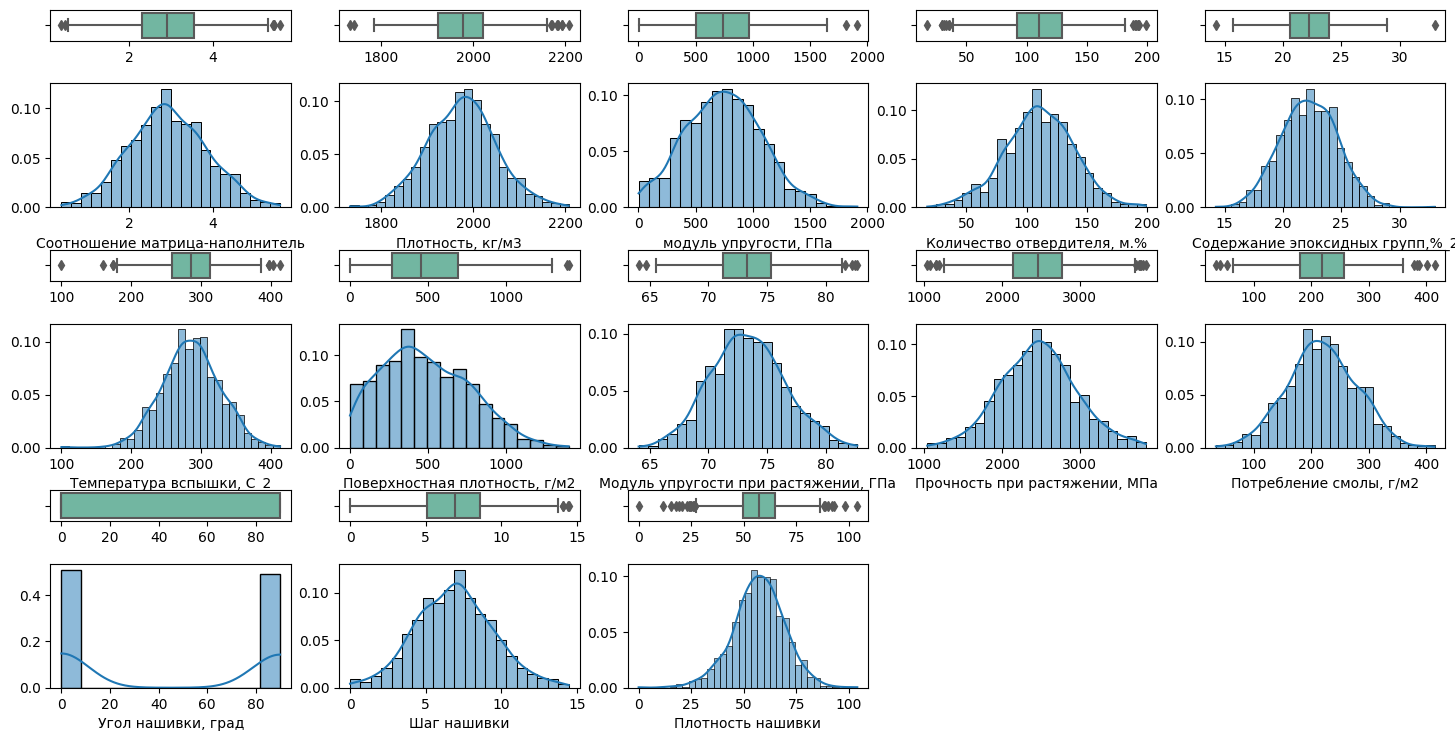

In [21]:
hisboxplt(work_df, 5)

### Есть два распространенных способа удалить выбросы метод межквартильного диапазона и метод трех сигм

метод межквартильного диапазона

In [22]:
work_df.shape[0] - method_iq(work_df).shape[0]

87

 метод трех сигм

In [23]:
work_df.shape[0] - method_3s(work_df).shape[0]

24

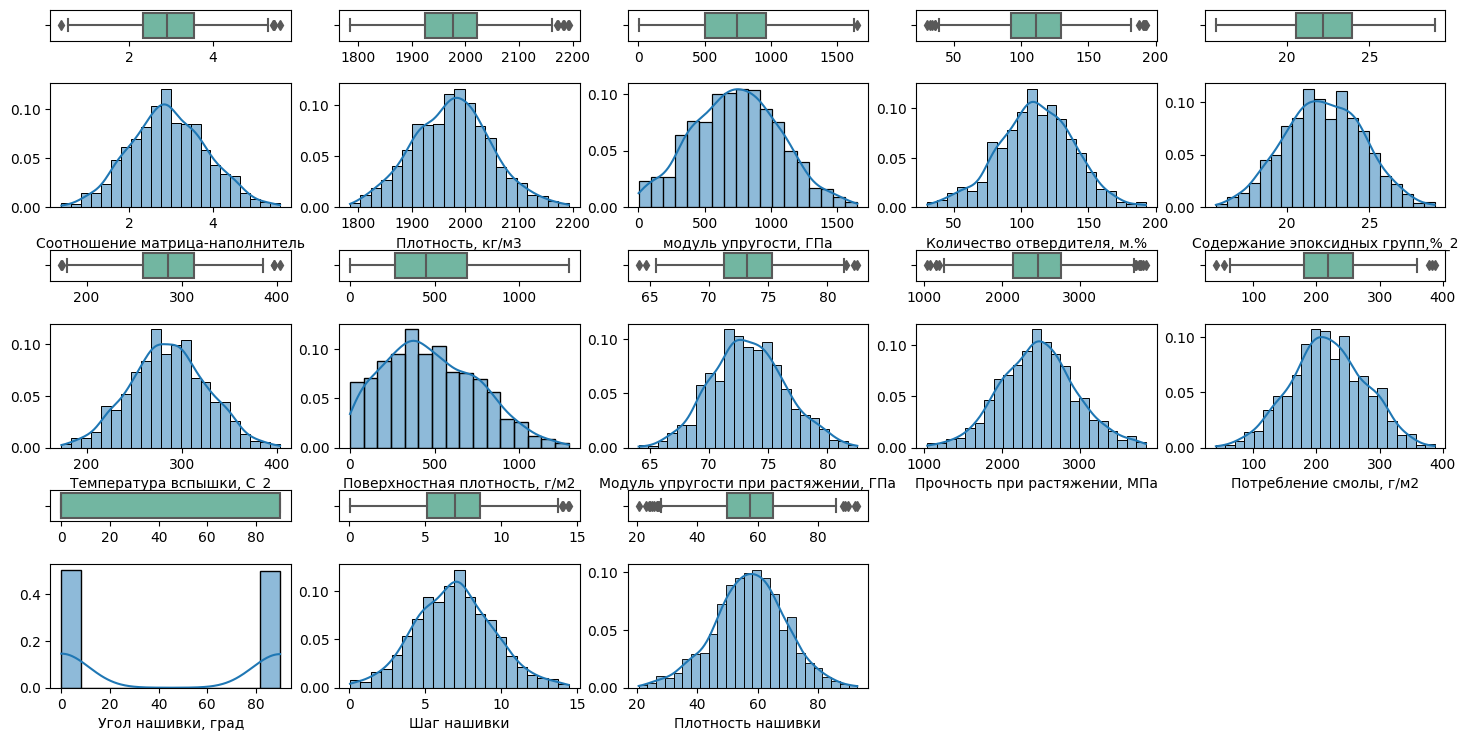

In [24]:
hisboxplt(method_3s(work_df), 5)

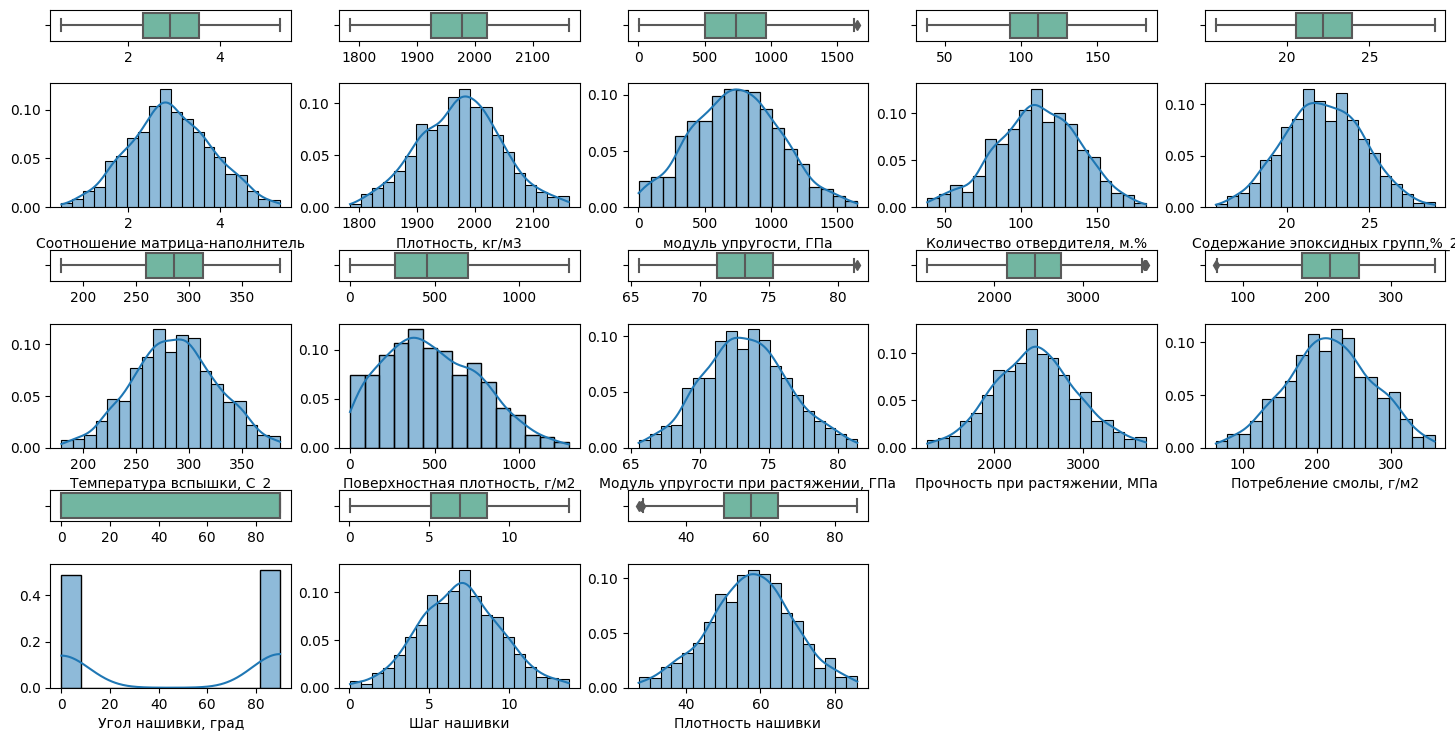

In [25]:
hisboxplt(method_iq(work_df), 5)

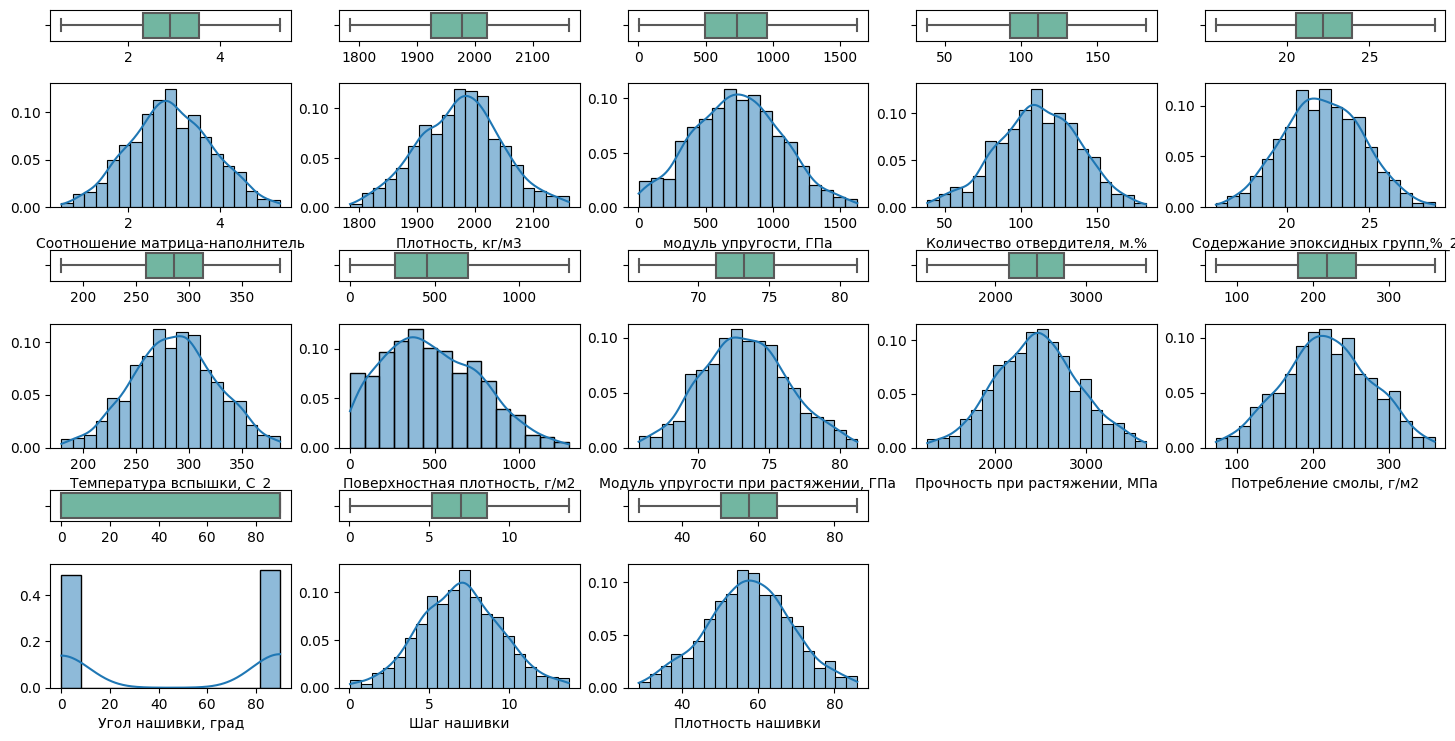

In [26]:
hisboxplt(method_iq(method_iq(method_iq(work_df))), 5)

In [27]:
clean_df = method_iq(method_iq(method_iq(work_df)))
clean_df.shape

(922, 13)

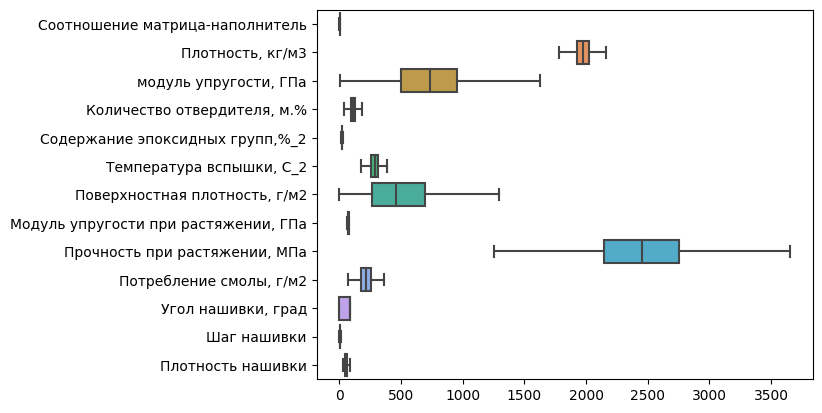

In [28]:
sns.boxplot(data = clean_df, orient="h")
plt.show()

### Тепловая карта корреляций
Никаких сильных корреляций нет.

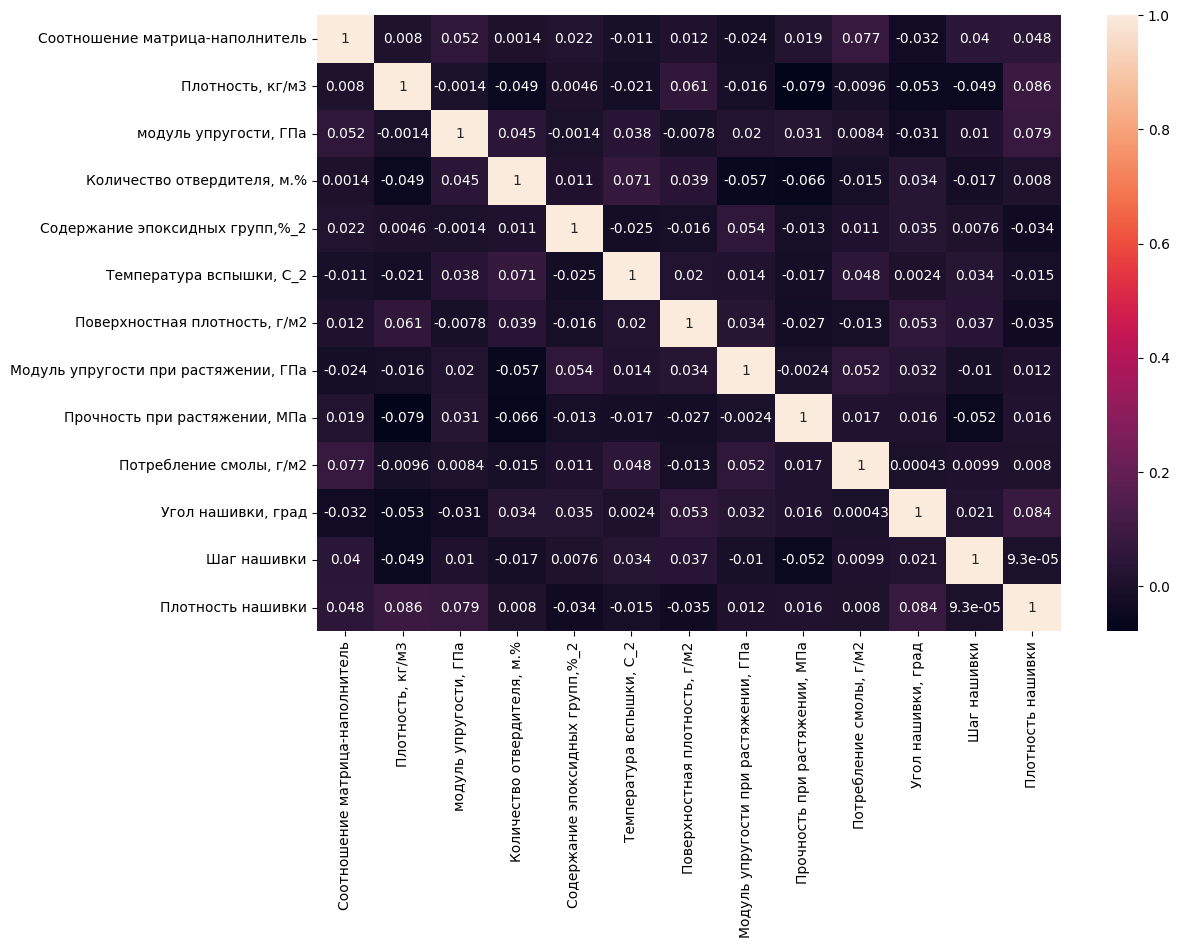

In [29]:
plt.figure(figsize=(12, 8))
sns.heatmap(clean_df.corr(), annot=True, )
plt.show()

### Попарные графики рассеяния точек
По-прежнему ничего похожего на линейные зависимости нет. Серьезных выбросов не видно.


In [30]:
#sns.pairplot(clean_df)

### Среднее, медианное значение для каждой колонки

In [31]:
clean_df.describe().loc[['mean', '50%']].T

,mean,50%
Соотношение матрица-наполнитель,2.927964,2.907832
"Плотность, кг/м3",1974.118744,1977.321002
"модуль упругости, ГПа",736.119982,736.178435
"Количество отвердителя, м.%",111.136066,111.162090
"Содержание эпоксидных групп,%_2",22.200570,22.177681
"Температура вспышки, С_2",286.181128,286.220763
"Поверхностная плотность, г/м2",482.429070,457.732246
"Модуль упругости при растяжении, ГПа",73.303464,73.247594
"Прочность при растяжении, МПа",2461.491315,2455.974462
"Потребление смолы, г/м2",218.048059,218.697660


In [32]:
clean_df.median() / full_df.mean() * 100

Соотношение матрица-наполнитель          99.231033
Плотность, кг/м3                        100.080280
модуль упругости, ГПа                    99.493894
Количество отвердителя, м.%             100.534790
Содержание эпоксидных групп,%_2          99.700109
Температура вспышки, С_2                100.118445
Поверхностная плотность, г/м2            94.821227
Модуль упругости при растяжении, ГПа     99.889570
Прочность при растяжении, МПа            99.556193
Потребление смолы, г/м2                 100.125681
Угол нашивки, град                      203.379722
Шаг нашивки                             101.067364
Плотность нашивки                       100.752871
dtype: float64

Поверхностная плотность, г/м2: **94.821227**

## Предобработка данных

### Извлечение корня делает распределение визуально правильнее


In [33]:
sqrt_df = clean_df.copy()
sqrt_df['Поверхностная плотность, г/м2'] = np.sqrt(sqrt_df['Поверхностная плотность, г/м2'])


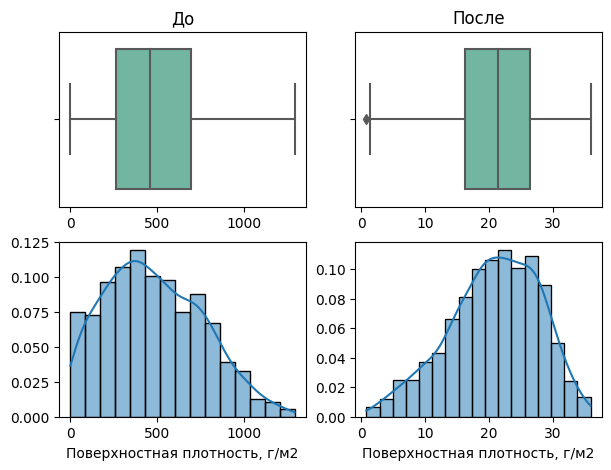

In [34]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(2, 2, 2)
sns.boxplot(data=sqrt_df, x=sqrt_df['Поверхностная плотность, г/м2'],
            palette='Set2', ax=ax).set(xlabel=None, title='После')
ax = fig.add_subplot(2, 2, 4)
sns.histplot(x=sqrt_df['Поверхностная плотность, г/м2'],
             kde=True, ax=ax, data=sqrt_df, stat='probability').set(ylabel=None)
ax = fig.add_subplot(2, 2, 1)
sns.boxplot(data=clean_df, x=clean_df['Поверхностная плотность, г/м2'],
            palette='Set2', ax=ax).set(xlabel=None, title='До')
ax = fig.add_subplot(2, 2, 3)
sns.histplot(x=clean_df['Поверхностная плотность, г/м2'],
             kde=True, ax=ax, data=clean_df, stat='probability').set(ylabel=None)
plt.show()

Появился выброс. Удаляю

In [35]:
clean_df = method_iq(sqrt_df)
clean_df.shape

(921, 13)

### Нормализация

Оценка плотности ядра

In [43]:
X_df = clean_df.copy().drop(targ_cols, axis=1)

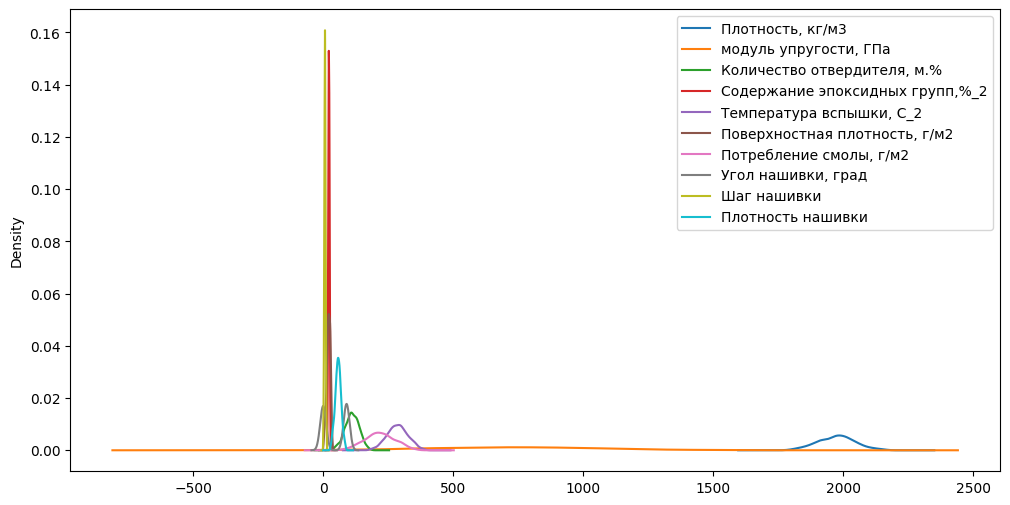

                                         max          min
Плотность, кг/м3                 2161.565216  1784.482245
модуль упругости, ГПа            1628.000000     2.436909
Количество отвердителя, м.%       181.828448    38.668500
Содержание эпоксидных групп,%_2    28.955094    15.695894
Температура вспышки, С_2          386.067992   179.374391
Поверхностная плотность, г/м2      35.935221     1.291512
Потребление смолы, г/м2           359.052220    72.530873
Угол нашивки, град                 90.000000     0.000000
Шаг нашивки                        13.732404     0.037639
Плотность нашивки                  86.012427    28.661632


In [55]:
fig, ax = plt.subplots(figsize = (12, 6))
X_df.plot(kind = 'kde', ax = ax)
plt.show()
print(X_df.describe().loc[['max', 'min']].T)

Как и было замечено ранее данные имеют разный масштаб. Требуется нормализазия

MinMaxScaler

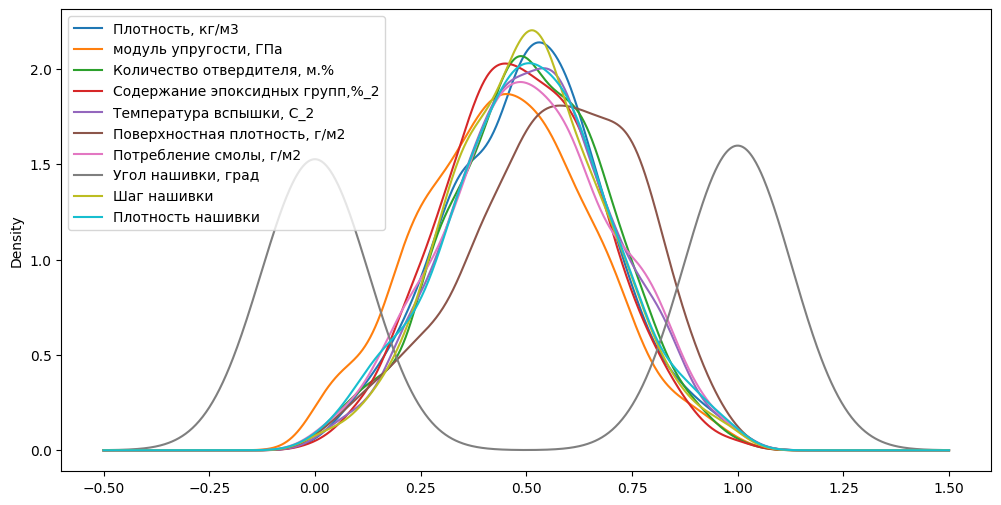

                                 max  min
Плотность, кг/м3                 1.0  0.0
модуль упругости, ГПа            1.0  0.0
Количество отвердителя, м.%      1.0  0.0
Содержание эпоксидных групп,%_2  1.0  0.0
Температура вспышки, С_2         1.0  0.0
Поверхностная плотность, г/м2    1.0  0.0
Потребление смолы, г/м2          1.0  0.0
Угол нашивки, град               1.0  0.0
Шаг нашивки                      1.0  0.0
Плотность нашивки                1.0  0.0


In [52]:
scaler = MinMaxScaler()
scaler.fit(X_df)
test_df = pd.DataFrame(scaler.transform(X_df), columns=X_df.columns)
fig, ax = plt.subplots(figsize = (12, 6))
test_df.plot(kind = 'kde', ax = ax)
plt.show()
print(test_df.describe().loc[['max', 'min']].T)

StandardScaler

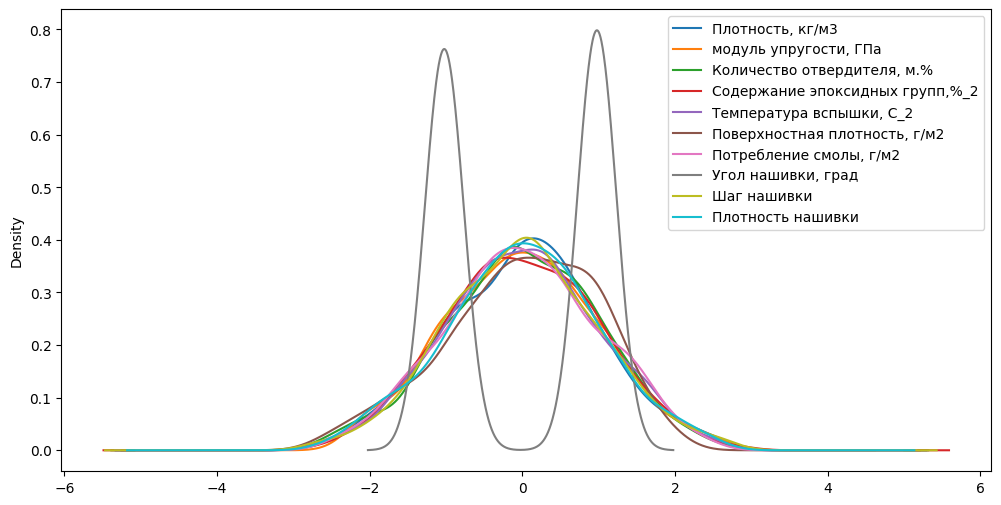

                                      max       min
Плотность, кг/м3                 2.638375 -2.670005
модуль упругости, ГПа            2.724160 -2.243963
Количество отвердителя, м.%      2.642366 -2.708763
Содержание эпоксидных групп,%_2  2.821362 -2.718041
Температура вспышки, С_2         2.538190 -2.710834
Поверхностная плотность, г/м2    2.152936 -2.783296
Потребление смолы, г/м2          2.470436 -2.547182
Угол нашивки, град               0.977453 -1.023067
Шаг нашивки                      2.704921 -2.744008
Плотность нашивки                2.557817 -2.599938


In [53]:
scaler = StandardScaler()
scaler.fit(X_df)
test_df = pd.DataFrame(scaler.transform(X_df), columns=X_df.columns)
fig, ax = plt.subplots(figsize = (12, 6))
test_df.plot(kind = 'kde', ax = ax)
plt.show()
print(test_df.describe().loc[['max', 'min']].T)

Normalizer

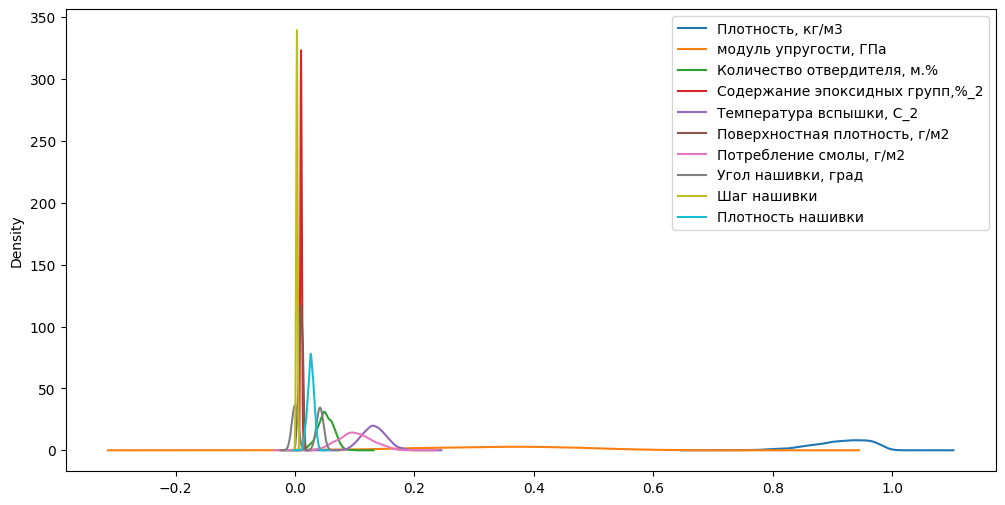

                                      max       min
Плотность, кг/м3                 0.988471  0.760508
модуль упругости, ГПа            0.630041  0.001180
Количество отвердителя, м.%      0.093679  0.017797
Содержание эпоксидных групп,%_2  0.014554  0.006732
Температура вспышки, С_2         0.188836  0.076169
Поверхностная плотность, г/м2    0.018311  0.000558
Потребление смолы, г/м2          0.169601  0.033108
Угол нашивки, град               0.048587  0.000000
Шаг нашивки                      0.006717  0.000016
Плотность нашивки                0.041404  0.012393


In [54]:
scaler = Normalizer()
scaler.fit(X_df)
test_df = pd.DataFrame(scaler.transform(X_df), columns=X_df.columns)
fig, ax = plt.subplots(figsize = (12, 6))
test_df.plot(kind = 'kde', ax = ax)
plt.show()
print(test_df.describe().loc[['max', 'min']].T)

## Обучить нескольких моделей для прогноза модуля упругости при растяжении и прочности при растяжении.

### Обучение пяти моделей, добавление оценок в таблицу

In [220]:
targ_cols = ['Модуль упругости при растяжении, ГПа',
             'Прочность при растяжении, МПа',
            ]
cur_target_cols=['Прочность при растяжении, МПа']

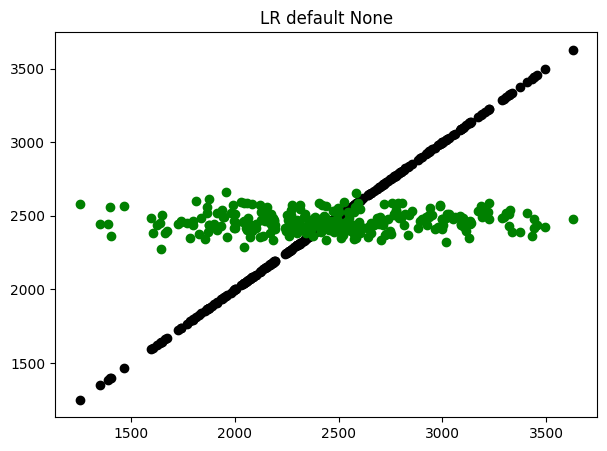


  note: LR default None
    r2: -0.004317775536882396
   MAE: 377.3173289742848
   MSE: 221250.1768684405
params: [LinearRegression()]
transf: [None]


In [221]:
# Линейная регрессия
est_df = pd.concat([est_df,
                    est('LR default None',LinearRegression(), clean_df,
                        drw=True, prt=True)
                    ], axis=0, ignore_index=True
                   )

In [225]:
est_df

,note,r2,MAE,MSE,params,transf
0,LR default,1.000000,4.369722e-13,3.068247e-25,LinearRegression(),NaN
1,SVR default,-0.001455,3.793140e+02,2.242639e+05,SVR(),NaN
2,RF default,-0.026416,3.807131e+02,2.298534e+05,"(DecisionTreeRegressor(max_features=1.0, rando...",NaN
3,GBR default,-0.051032,3.915547e+02,2.353659e+05,([DecisionTreeRegressor(criterion='friedman_ms...,NaN
4,Lasso default,-0.001402,3.787233e+02,2.242519e+05,Lasso(),NaN
5,LR default,-0.014642,3.775954e+02,2.235247e+05,LinearRegression(),NaN
6,LR default Norm,-0.014642,3.775954e+02,2.235247e+05,LinearRegression(),NaN
7,LR default Norm,-0.014642,3.775954e+02,2.235247e+05,LinearRegression(),NaN
8,LR default StandardScaler,-0.004318,3.773173e+02,2.212502e+05,LinearRegression(),NaN
9,LR default MinMaxScaler,-0.004318,3.773173e+02,2.212502e+05,LinearRegression(),NaN


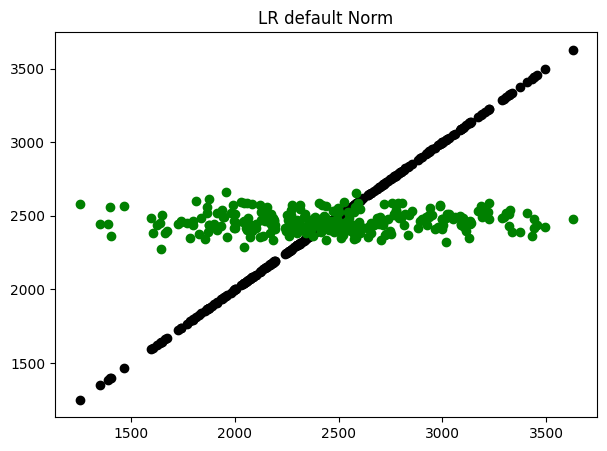


  note: LR default Norm
    r2: -0.004317775536882396
   MAE: 377.3173289742848
   MSE: 221250.1768684405
params: [LinearRegression()]
transf: [None]


In [219]:
# Линейная регрессия
est_df = pd.concat([est_df,
                    est('LR default Norm',LinearRegression(), clean_df,
                        drw=True, prt=True)
                    ], axis=0, ignore_index=True
                   )

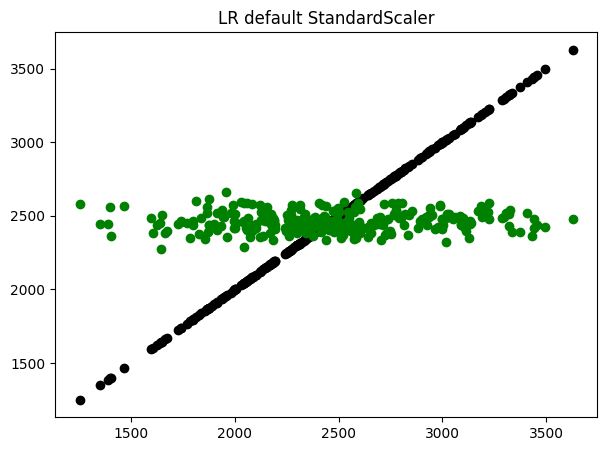


  note: LR default StandardScaler
    r2: -0.0043177755368821735
   MAE: 377.31732897428475
   MSE: 221250.17686844044
params: [LinearRegression()]
transf: [StandardScaler()]


In [218]:
# Линейная регрессия
est_df = pd.concat([est_df,
                    est('LR default StandardScaler',LinearRegression(), clean_df,
                        drw=True, prt=True, transformer=StandardScaler())
                    ], axis=0, ignore_index=True
                   )

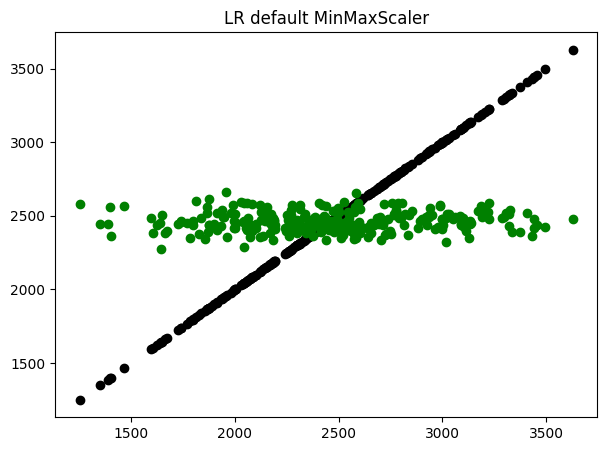

In [208]:
# Линейная регрессия
est_df = pd.concat([est_df,
                    est('LR default MinMaxScaler',LinearRegression(), clean_df,
                        drw=True, transformer=MinMaxScaler())
                    ], axis=0, ignore_index=True
                   )

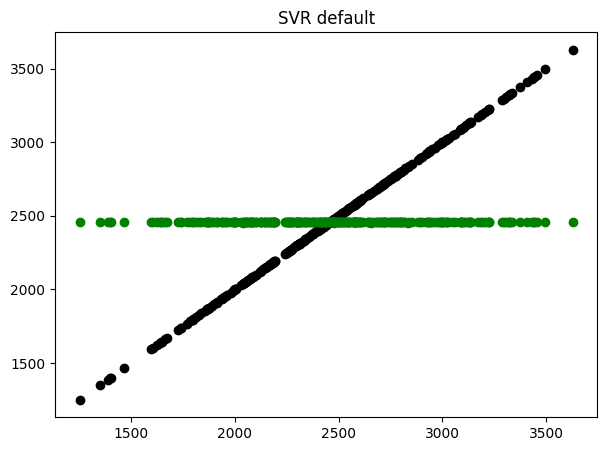

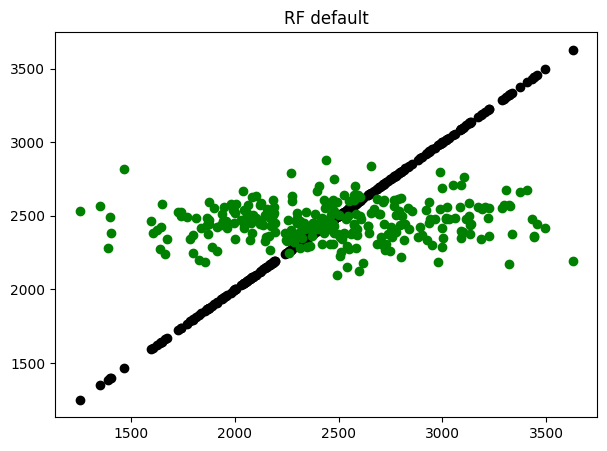

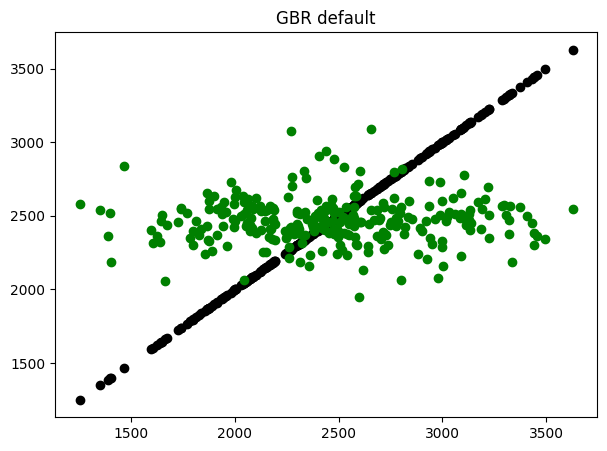

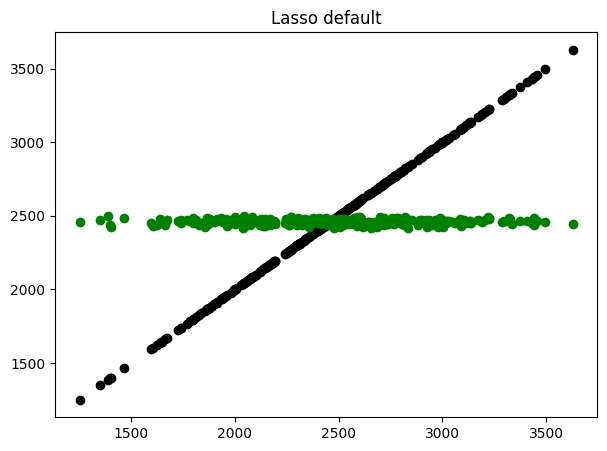

In [224]:


# Метод опорных векторов SVR(C=400,epsilon=2)
est_df = pd.concat([est_df,
                    est('SVR default', SVR(), clean_df, 
                        drw=True, transformer=Normalizer())
                    ], axis=0, ignore_index=True
                   )

# Случайный лес
est_df = pd.concat([est_df,
                    est('RF default', RandomForestRegressor(), clean_df,
                        drw=True, transformer=Normalizer())
                    ], axis=0, ignore_index=True
                   )

# Градиентный бустинг
est_df = pd.concat([est_df,
                    est('GBR default', GradientBoostingRegressor(), clean_df,
                        drw=True, transformer=Normalizer())
                    ], axis=0, ignore_index=True
                   )

# Лассо регрессор
est_df = pd.concat([est_df,
                    est('Lasso default', Lasso(), clean_df,
                        drw=True, transformer=Normalizer())
                    ], axis=0, ignore_index=True
                   )

In [226]:
print(est_df.drop(['params'], axis=1).sort_values(by='r2', ascending=False))

                         note        r2           MAE           MSE  \
0                  LR default  1.000000  4.369722e-13  3.068247e-25   
10            LR default None  1.000000  1.200894e-12  1.818416e-24   
13            LR default None  1.000000  1.200894e-12  1.818416e-24   
14            LR default Norm  1.000000  1.200894e-12  1.818416e-24   
24                SVR default -0.000224  3.753244e+02  2.203483e+05   
4               Lasso default -0.001402  3.787233e+02  2.242519e+05   
23              Lasso default -0.001402  3.787233e+02  2.242519e+05   
1                 SVR default -0.001455  3.793140e+02  2.242639e+05   
20                SVR default -0.001455  3.793140e+02  2.242639e+05   
27              Lasso default -0.001608  3.761153e+02  2.206532e+05   
16  LR default StandardScaler -0.004318  3.773173e+02  2.212502e+05   
17  LR default StandardScaler -0.004318  3.773173e+02  2.212502e+05   
8   LR default StandardScaler -0.004318  3.773173e+02  2.212502e+05   
9     

Результат стабильно отвратительный, но не надо отчаиваться.

### При построении моделей провести поиск гиперпараметров модели с помощью поиска по сетке с перекрестной проверкой, количество блоков равно 10.

### RandomForestRegressor
* n_estimators — число «деревьев» в «случайном лесу».
* max_features — число признаков для выбора расщепления.
* max_depth — максимальная глубина деревьев.
* min_samples_split — минимальное число объектов, необходимое для того, чтобы узел дерева мог бы расщепиться.
* min_samples_leaf — минимальное число объектов в листьях.
* bootstrap — использование для построения деревьев подвыборки с возвращением.


In [ ]:
RandomForestRegressor().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Fitting 3 folds for each of 33 candidates, totalling 99 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 99.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py", line 340, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/utils/_para

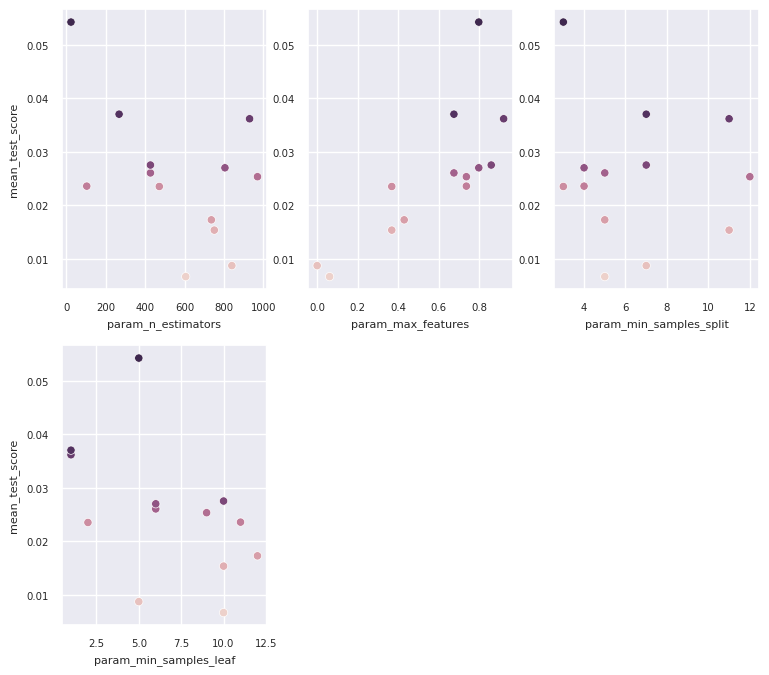

             note        r2         MAE            MSE
13    GBR default  0.969119   66.636889    7118.126820
3     GBR default  0.969010   66.746314    7143.381535
23    GBR default  0.968985   66.801128    7149.183118
12     RF default  0.967029   67.364283    7599.926052
22     RF default  0.966690   66.995894    7678.127752
2      RF default  0.966346   67.529189    7757.395478
0      LR default  0.962060   72.709816    8745.393205
10     LR default  0.962060   72.709816    8745.393205
20     LR default  0.962060   72.709816    8745.393205
24  Lasso default  0.954199   78.549770   10557.415941
14  Lasso default  0.954199   78.549770   10557.415941
4   Lasso default  0.954199   78.549770   10557.415941
11    SVR default  0.059680  364.668373  216748.797823
1     SVR default  0.059680  364.668373  216748.797823
21    SVR default  0.059680  364.668373  216748.797823
9   Lasso default  0.004040  378.559012  229574.166959
5      LR default  0.003461  379.440218  229707.719687
26        

In [ ]:
tmp = rs_viz('RF', RandomForestRegressor(), w_df, {
    'n_estimators': [int(x) for x in np.linspace(start = 10, 
                                                 stop = 1000,
                                                 num = 200)],
    'max_features': [float(x) for x in np.linspace(0.001, 3, 50)],
    'min_samples_split': [int(x) for x in np.linspace(start = 1,
                                                      stop = 12,
                                                      num = 12)],
    'min_samples_leaf': [int(x) for x in np.linspace(start = 1,
                                                     stop = 12,
                                                     num = 12)]
                                                   }
             )
est_df = pd.concat([est_df, tmp[0]], ignore_index=True)
print(est_df.drop(['params'], axis=1).sort_values(by='r2', ascending=False))
print()
print(*tmp[0]['params'])

In [ ]:
GSCV = GridSearchCV(RandomForestRegressor(), {
    'n_estimators': [220, 230, 240],
    'max_features': [7, 8, 9],
    'min_samples_split': [2, 9, 10],
    'min_samples_leaf': [2],
    },
    cv=10, scoring='r2')

X_train, X_test, y_train, y_test = tt_split(w_df)
GSCV.fit(X_train, y_train)
print(GSCV.best_estimator_ )
print()
est_df = pd.concat([est_df,
                    est('GS-RF', GSCV.best_estimator_, w_df)
                    ], ignore_index=True
                   )
est_df.drop('params', axis=1).sort_values(by='r2', ascending=False)


RandomForestRegressor(max_features=7, min_samples_leaf=2, n_estimators=240)



,note,r2,MAE,MSE
3,GBR default,0.964753,67.374954,7834.592082
2,RF default,0.964149,68.366218,7968.682746
4,Lasso default,0.951785,78.588759,10716.959993
1,SVR default,0.055383,362.557656,209963.843646
0,LR default,-0.027073,381.852083,228291.742470
5,RS-RF,-0.033884,386.579214,229805.583942
6,GS-RF,-0.037696,388.235541,230653.057977


### SVR
* kernel {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}, default=’rbf’ Указывает тип ядра, который будет использоваться в алгоритме. Он должен быть одним из «линейных», «полигональных», «rbf», «сигмоидальных», «предварительно вычисленных» или вызываемых.

* degree int, default=3 Степень полиномиальной функции ядра («поли»). Игнорируется всеми другими ядрами.

* gamma {‘scale’, ‘auto’} or float, default=’scale’ Коэффициент ядра для «rbf», «poly» и «sigmoid». Eсли передается gamma='scale' (по умолчанию), то в качестве значения гаммы используется 1 / (n_features * X.var ()), если «авто», использует 1 / n_features.

* coef0 float, default=0.0 Независимый член в функции ядра. Это имеет значение только в «поли» и «сигмовидной».

* tol float, default=1e-3 Толерантность к критерию остановки.

* C float, default=1.0 Параметр регуляризации. Сила регуляризации обратно пропорциональна C. Должна быть строго положительной. Штраф представляет собой квадратичный штраф l2.

* epsilon float, default=0.1 Эпсилон в модели Эпсилон-СВР. Он определяет эпсилон-трубку, в пределах которой нет штрафных санкций в функции потери тренировки с очками, предсказанными на расстоянии эпсилон от фактического значения.

* shrinking bool, default=True Использовать ли эвристику сжатия.

* cache_size float, default=200 размер кэша ядра (в мегабайтах).

* verbose bool, default=False Включить многословный вывод.Обратите внимание,что эта настройка использует преимущества настройки времени выполнения каждого процесса в libsvm,которая,если она включена,может работать некорректно в многопоточном контексте.

* max_iter int, default=-1 Жесткий лимит на итерации внутри решателя,или -1 без ограничения.

In [ ]:
SVR().get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Fitting 6 folds for each of 33 candidates, totalling 198 fits


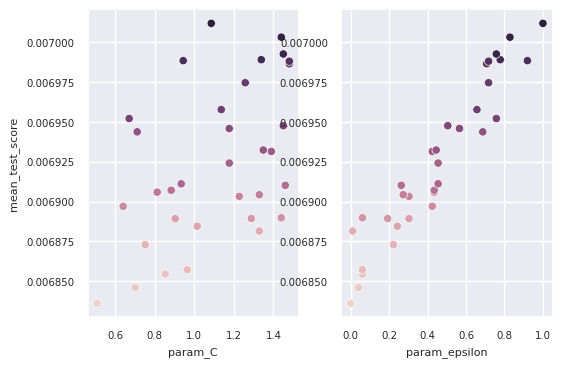

SVR(C=0.5101, epsilon=0.001)

            note        r2         MAE            MSE
4  Lasso default  0.003706  379.372039  229651.231660
0     LR default  0.003461  379.440218  229707.719687
5         RS-SVR -0.000866  376.574425  230705.087827
1    SVR default -0.000873  376.578643  230706.704344
2     RF default -0.058935  393.219543  244090.149244
3    GBR default -0.065480  391.029984  245598.804852


In [ ]:
tmp = rs_viz('SVR', SVR(), w_df, {
    'C': [round(x, 4) for x in np.linspace(start = 0.5,
                                                stop = 1.5,
                                                num = 100)],
    'epsilon': [round(x, 4) for x in np.linspace(start = 0.001,
                                                      stop = 1,
                                                      num = 100)],
    #'kernel': ['rbf'],
    #'gamma': ['scale']
    #[round(x, 3) for x in np.linspace(start = 0.001, stop = 0.999, num = 5)]
    },
    ncols=2)

est_df = pd.concat([est_df, tmp[0]], ignore_index=True)
print(*tmp[0]['params'])
print()
print(est_df.drop(['params'], axis=1).sort_values(by='r2', ascending=False))

In [ ]:
GSCV = GridSearchCV(SVR(), {
    'C': [980, 1100],
    'epsilon': [7.5, 10.6, 12]
    },
    cv=10, scoring='r2')

X_train, X_test, y_train, y_test = tt_split(w_df)
GSCV.fit(X_train, y_train)
print(GSCV.best_estimator_ )
print()
est_df = pd.concat([est_df,
                    pd.DataFrame(est('GS-SVR',
                    GSCV.best_estimator_, w_df))],
                   ignore_index=True)
est_df.drop('params', axis=1).sort_values(by='r2', ascending=False)

SVR(C=980, epsilon=7.5)



,note,r2,MAE,MSE
3,GBR default,0.964753,67.374954,7834.592082
2,RF default,0.964149,68.366218,7968.682746
4,Lasso default,0.951785,78.588759,10716.959993
1,SVR default,0.055383,362.557656,209963.843646
7,RS-SVR,-0.012868,375.527107,225134.410324
8,GS-SVR,-0.018804,379.320875,226453.792506
0,LR default,-0.027073,381.852083,228291.742470
5,RS-RF,-0.033884,386.579214,229805.583942
6,GS-RF,-0.037696,388.235541,230653.057977


##  GradientBoostingRegressor
* learning_rate : float, optional (default=0.1) ключевой для настройки параметр
* n_estimators: int (default=100) Количество «boosting stages» при обучении модели градиентного бустинга
* max_depth: integer, optional (default=3) Максимальная глубина отдельных регрессионных оценок. Максимальная глубина ограничивает количество узлов в дереве.
* criterion: string, optional (default=«friedman_mse») Функция измерения качества разделения. Поддерживаемые критерии: «friedman_mse» для среднеквадратичной ошибки с оценкой улучшения по Фридману, «mse» для среднеквадратичной ошибки и «mae» для средней абсолютной ошибки. Значение по умолчанию «friedman_mse», как правило, является лучшим, поскольку в некоторых случаях оно может обеспечить лучшее приближение.
* min_samples_split: int, float, optional (default=2) Минимальное количество примеров, необходимое для продолжения достраивания дерева в данной вершине при обучении. Попробуем изменить его.
* min_samples_leaf: int, float, optional (default=1) Минимальное количество примеров, которое может находиться в листе дерева после обучения. Увеличение этого параметра снижает качество предсказания на тренировочной выборке (т. к. при меньшем значении деревья, составляющие ансамбль в большей степени подстраиваются под каждый конкретный пример из обучающей выборки) и, если повезет, повышает качество на валидационной. То есть, по крайней мере теоретически, помогает бороться с переобучением.
* min_weight_fraction_leaf: float, optional (default=0.) Минимальная часть примеров, необходимая для формирования листа. По умолчанию их количество равно нулю, то есть не задает никакого ограничения. По идее, увеличение значения этого параметра должно препятствовать переобучению, подобно параметру mean_samples_leaf.

In [ ]:
gbr = make_pipeline(StandardScaler(), GradientBoostingRegressor())

In [ ]:
GradientBoostingRegressor().get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

Fitting 6 folds for each of 33 candidates, totalling 198 fits


/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
24 fits failed out of a total of 198.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_gb.py", line 420, in fit
    self._validate_params()
  File "/usr/local/lib/python3.9/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.9/dist-packages/sklearn/utils/_param_

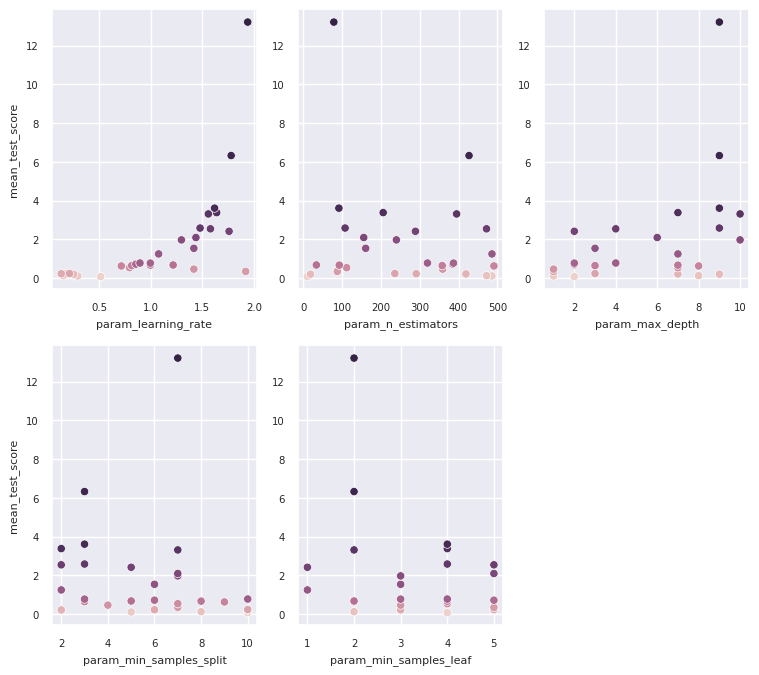

0    ([DecisionTreeRegressor(criterion='friedman_ms...
Name: params, dtype: object

            note        r2         MAE            MSE
4  Lasso default  0.003706  379.372039  229651.231660
0     LR default  0.003461  379.440218  229707.719687
5         RS-SVR -0.000866  376.574425  230705.087827
1    SVR default -0.000873  376.578643  230706.704344
6         RS-GBR -0.024736  384.628901  236207.157949
2     RF default -0.058935  393.219543  244090.149244
3    GBR default -0.065480  391.029984  245598.804852


In [ ]:
tmp = rs_viz('GBR', GradientBoostingRegressor(), w_df,
    {
    'learning_rate': [
        round(x, 4) for x in np.linspace(0.01, 2, 100)],
    'n_estimators': [
        int(x) for x in np.linspace(10, 500, 490)],
    'max_depth': [
        int(x) for x in np.linspace(1, 10, 10)],
    'min_samples_split': [
        int(x) for x in np.linspace(1, 10, 10)],
    'min_samples_leaf': [
        int(x) for x in np.linspace(1, 5, 5)],
    },
    ncols=3)

est_df = pd.concat([est_df, tmp[0]], ignore_index=True)
print(tmp[0]['params'])
print()
print(est_df.drop(['params'], axis=1).sort_values(by='r2', ascending=False))



### подбор по сетке

In [ ]:
GSCV = GridSearchCV(GradientBoostingRegressor(), {
    'learning_rate': [0.2, 0.211, 0.3],
    'n_estimators': [133, 520],
    'max_depth': [2, 3, 4],
    'min_samples_split': [2, 6, 10],
    'min_samples_leaf': [1, 4],
    },
    cv=10, scoring='r2')

X_train, X_test, y_train, y_test = tt_split(w_df)
GSCV.fit(X_train, y_train)

print(GSCV.best_estimator_ )
print()
est_df = pd.concat([est_df,
                    pd.DataFrame(est('GS-GBR',
                    GSCV.best_estimator_, w_df))],
                   ignore_index=True)
est_df.drop('params', axis=1).sort_values(by='r2', ascending=False)

GradientBoostingRegressor(learning_rate=0.211, max_depth=2,
                          min_samples_split=10, n_estimators=133)



,note,r2,MAE,MSE
3,GBR default,0.964753,67.374954,7834.592082
2,RF default,0.964149,68.366218,7968.682746
4,Lasso default,0.951785,78.588759,10716.959993
1,SVR default,0.055383,362.557656,209963.843646
7,RS-SVR,-0.012868,375.527107,225134.410324
8,GS-SVR,-0.018804,379.320875,226453.792506
0,LR default,-0.027073,381.852083,228291.742470
5,RS-RF,-0.033884,386.579214,229805.583942
6,GS-RF,-0.037696,388.235541,230653.057977
10,GS-GBR,-0.139691,402.494793,253323.814490


## Lasso


In [ ]:
Lasso().get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

Fitting 6 folds for each of 33 candidates, totalling 198 fits


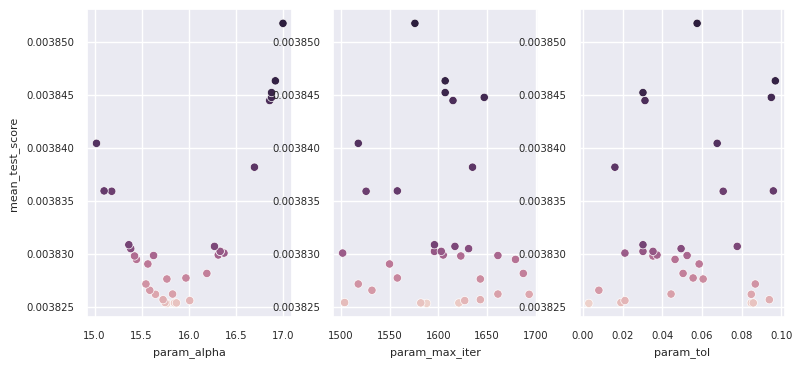

Lasso(alpha=15.7677, max_iter=1588, tol=0.00304)

             note        r2         MAE            MSE
18       RS-Lasso  0.006972  378.375938  228898.333770
17       RS-Lasso  0.006972  378.375938  228898.333770
16       RS-Lasso  0.006972  378.375938  228898.333770
6        RS-Lasso  0.006965  378.352019  228899.960707
15       RS-Lasso  0.006961  378.353462  228900.919033
9        RS-Lasso  0.006954  378.355627  228902.357137
8        RS-Lasso  0.006944  378.359234  228904.755617
13       RS-Lasso  0.006940  378.360676  228905.715584
14       RS-Lasso  0.006940  378.360676  228905.715584
10       RS-Lasso  0.006931  378.363926  228907.879086
11       RS-Lasso  0.006915  378.369333  228911.482274
12       RS-Lasso  0.006915  378.369333  228911.482274
0        RS-Lasso  0.006840  378.395311  228928.858016
7        RS-Lasso  0.006766  378.420560  228945.848401
5   Lasso default  0.003706  379.372039  229651.231660
1      LR default  0.003461  379.440218  229707.719687
2     SVR defau

In [ ]:
tmp = rs_viz('Lasso', Lasso(), w_df,
    {
    'alpha': [round(x, 4) for x in np.linspace(15, 17, 100)],       
    #'fit_intercept': [False, True],
    'max_iter': [int(x) for x in np.linspace(1500, 1700, 100)],
    #'positive': [False, True],
    #'precompute': [True],
     'tol': [float(x) for x in np.linspace(0.00001, 0.1, 100)]
    },
    ncols=3)

est_df = pd.concat([est_df, tmp[0]], ignore_index=True)
print(*tmp[0]['params'])
print()
print(est_df.drop(['params'], axis=1).sort_values(by='r2', ascending=False))
a = est_df.sort_values(by='r2', ascending=False).iloc[:6, 4]
print(* a, sep='\n')

Fitting 6 folds for each of 33 candidates, totalling 198 fits


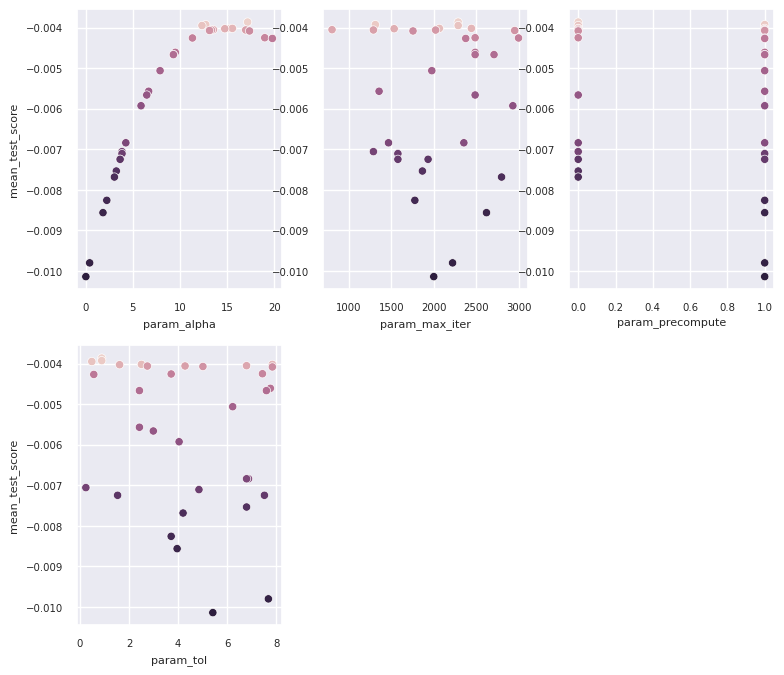

Lasso(alpha=17.1731, max_iter=2288, tol=0.8888977777777777)

             note        r2         MAE            MSE
24       RS-Lasso  0.007207  378.266985  228844.241604
23  Lasso default  0.006972  378.375938  228898.333770
18       RS-Lasso  0.006972  378.375938  228898.333770
17       RS-Lasso  0.006972  378.375938  228898.333770
16       RS-Lasso  0.006972  378.375938  228898.333770
6        RS-Lasso  0.006965  378.352019  228899.960707
15       RS-Lasso  0.006961  378.353462  228900.919033
9        RS-Lasso  0.006954  378.355627  228902.357137
8        RS-Lasso  0.006944  378.359234  228904.755617
13       RS-Lasso  0.006940  378.360676  228905.715584
14       RS-Lasso  0.006940  378.360676  228905.715584
10       RS-Lasso  0.006931  378.363926  228907.879086
12       RS-Lasso  0.006915  378.369333  228911.482274
11       RS-Lasso  0.006915  378.369333  228911.482274
0        RS-Lasso  0.006840  378.395311  228928.858016
7        RS-Lasso  0.006766  378.420560  228945.848401
5   

In [ ]:
tmp = rs_viz('Lasso', Lasso(), w_df,
    {
    'alpha': [
        round(x, 4) for x in np.linspace(start = 0.01, stop = 20, num = 100)],
    'max_iter': [
        int(x) for x in np.linspace(start = 800, stop = 3000, num = 100)],
     'precompute': [
        False, True
     ],
     'tol': [
        float(x) for x in np.linspace(start = 0.00001, stop = 8, num = 100)]
    },
    ncols=3)

est_df = pd.concat([est_df, tmp[0]], ignore_index=True)
print(*tmp[0]['params'])
print()
print(est_df.drop(['params'], axis=1).sort_values(by='r2', ascending=False))

{'alpha': 0.1,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 2000,
 'positive': False,
 'precompute': True,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0006799999999999999,
 'warm_start': False}

In [ ]:
GSCV = GridSearchCV(Lasso(), {
    'alpha': [0.1, 0.4],
    'max_iter': [2000, 2250],
    'tol': [0.00068, 7.68]
    },
    cv=10, scoring='r2')

X_train, X_test, y_train, y_test = tt_split(w_df)
GSCV.fit(X_train, y_train)
print(GSCV.best_estimator_ )
print()
est_df = pd.concat([est_df,
                    pd.DataFrame(est('GS-Lasso',
                    GSCV.best_estimator_, w_df))],
                   ignore_index=True)
est_df.drop('params', axis=1).sort_values(by='r2', ascending=False)

Lasso(alpha=0.4, max_iter=2000, tol=0.00068)



,note,r2,MAE,MSE
3,GBR default,0.964753,67.374954,7834.592082
2,RF default,0.964149,68.366218,7968.682746
4,Lasso default,0.951785,78.588759,10716.959993
1,SVR default,0.055383,362.557656,209963.843646
11,RS-Lasso,-0.007591,375.601696,223961.490440
7,RS-SVR,-0.012868,375.527107,225134.410324
8,GS-SVR,-0.018804,379.320875,226453.792506
12,RS-Lasso,-0.025898,381.508788,228030.523827
13,GS-Lasso,-0.026948,381.816382,228264.051063
0,LR default,-0.027073,381.852083,228291.742470


In [ ]:
est_df.sort_values(by='r2', ascending=False)

,note,r2,MAE,MSE,params
3,GBR default,0.964753,67.374954,7834.592082,([DecisionTreeRegressor(criterion='friedman_ms...
2,RF default,0.964149,68.366218,7968.682746,"(DecisionTreeRegressor(max_features=1.0, rando..."
4,Lasso default,0.951785,78.588759,10716.959993,Lasso()
1,SVR default,0.055383,362.557656,209963.843646,SVR()
11,RS-Lasso,-0.007591,375.601696,223961.490440,"Lasso(alpha=43.5657, max_iter=2266, positive=T..."
7,RS-SVR,-0.012868,375.527107,225134.410324,"SVR(C=11.091, epsilon=0.001)"
8,GS-SVR,-0.018804,379.320875,226453.792506,"SVR(C=980, epsilon=7.5)"
12,RS-Lasso,-0.025898,381.508788,228030.523827,"Lasso(alpha=3.8465, max_iter=1288, tol=0.24243..."
13,GS-Lasso,-0.026948,381.816382,228264.051063,"Lasso(alpha=0.4, max_iter=2000, tol=0.00068)"
0,LR default,-0.027073,381.852083,228291.742470,LinearRegression()


In [ ]:
est_df.sort_values(by='r2', ascending=False)[:1].to_excel('Модуль упругости при растяжении,ГПа.xlsx')

In [ ]:
best = est_df.sort_values(by='r2', ascending=False)[:1].iloc[0, 4]

In [ ]:
dump(best, 'Прочность при растяжении.joblib')

['Прочность при растяжении.joblib']

In [ ]:
w_df

,Соотношение матрица-наполнитель,"Плотность, кг/м3","модуль упругости, ГПа","Количество отвердителя, м.%","Содержание эпоксидных групп,%_2","Температура вспышки, С_2","Поверхностная плотность, г/м2","Модуль упругости при растяжении, ГПа","Прочность при растяжении, МПа","Потребление смолы, г/м2","Угол нашивки, град",Шаг нашивки,Плотность нашивки
1,1.857143,2030.000000,738.736842,50.000000,23.750000,284.615385,14.491377,70.000000,3000.000000,220.000000,0,4.000000,60.000000
3,1.857143,2030.000000,738.736842,129.000000,21.250000,300.000000,14.491377,70.000000,3000.000000,220.000000,0,5.000000,47.000000
4,2.771331,2030.000000,753.000000,111.860000,22.267857,284.615385,14.491377,70.000000,3000.000000,220.000000,0,5.000000,57.000000
5,2.767918,2000.000000,748.000000,111.860000,22.267857,284.615385,14.491377,70.000000,3000.000000,220.000000,0,5.000000,60.000000
6,2.569620,1910.000000,807.000000,111.860000,22.267857,284.615385,14.491377,70.000000,3000.000000,220.000000,0,5.000000,70.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1018,2.271346,1952.087902,912.855545,86.992183,20.123249,324.774576,14.463703,73.090961,2387.292495,125.007669,90,9.076380,47.019770
1019,3.444022,2050.089171,444.732634,145.981978,19.599769,254.215401,18.725940,72.920827,2360.392784,117.730099,90,10.565614,53.750790
1020,3.280604,1972.372865,416.836524,110.533477,23.957502,248.423047,27.205565,74.734344,2662.906040,236.606764,90,4.161154,67.629684
1021,3.705351,2066.799773,741.475517,141.397963,19.246945,275.779840,25.327222,74.042708,2071.715856,197.126067,90,6.313201,58.261074


In [ ]:
model1=load('Прочность при растяжении.joblib')
transformer = Normalizer()
X = w_df.drop(targ_cols, axis=1)
y = w_df[cur_target_cols]
transformer.fit(X, y)
#Xy = transformer.transform(w_df)
#Xy_df = pd.DataFrame(Xy, columns=w_df.columns)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state = 42
    )

model = LinearRegression()
model.fit(transformer.transform(X_train), y_train)
p = model.predict(transformer.transform(X_test))

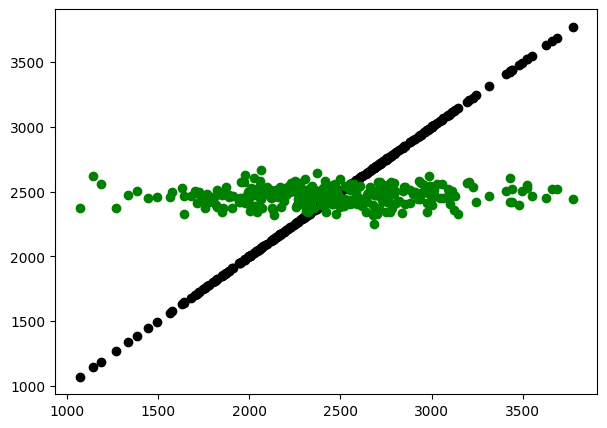

In [ ]:
plt.figure(figsize = (7, 5))
plt.scatter(y_test, y_test, color='black')
plt.scatter(y_test, p, color='green')

plt.show()
print()

## Написать нейронную сеть, которая будет рекомендовать соотношение матрица-наполнитель.

model.add(Dense(1,
                activation='linear',
                bias_initializer='glorot_normal',
                kernel_initializer='glorot_normal'))

sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

In [ ]:
import tensorflow as tf
from keras.models import Sequential # слоистая сеть
from keras import layers
from keras.layers import Dense, Dropout, Normalization #  слой
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

In [ ]:
cur_target_cols = ['Соотношение матрица-наполнитель']

In [ ]:
X_train = (np.array(X_train))
X_train.shape

In [ ]:
X_test = (np.array(X_test))
X_test

In [ ]:
y_train = (np.array(y_train).reshape(-1, 1))
y_train

In [ ]:
y_test = (np.array(y_test).reshape(-1, 1))
y_test

In [ ]:
X_train, X_test, y_train, y_test = tt_split(w_df,
                                            transformer=Normalizer(),
                                            nn=True)

In [ ]:
y_train

In [ ]:
model = Sequential()
#model.add(Normalization(input_dim=X_train.shape[1]))
# Добавим к модели полносвязный слой с 8 узлами:
model.add(Dense(256, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(128, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(y_train.shape[1]))

sgd = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss='mean_squared_error', optimizer=sgd)
#model.compile(optimizer = tf.keras.optimizers.Adam(0.001), loss = 'mean_squared_error', metrics = [tf.keras.metrics.RootMeanSquaredError()])  


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_11 (Dense)            (None, 256)               2816      
                                                                 
 dense_12 (Dense)            (None, 128)               32896     
                                                                 
 dense_13 (Dense)            (None, 128)               16512     
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 1)                 33        
                                                                 
Total params: 62,593
Trainable params: 62,593
Non-trai

<Axes: >

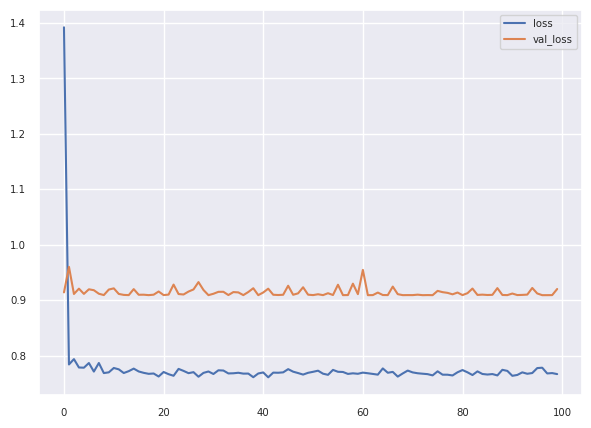

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=10,
                    epochs=100,
                    verbose=0,
                    validation_split=0.3,
                    )
pd.DataFrame(history.history).plot(figsize=(7, 5)) # метрики и функции потерь

In [ ]:
y_pred = model.predict(X_test)

10/10 [==============================] - 0s 2ms/step


In [ ]:
y_pred

In [ ]:
y_test.shape

(307, 1)

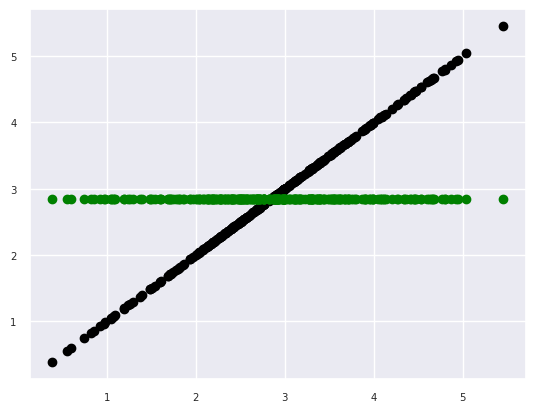

In [ ]:
# отрисовываем результат приближения нейросетью поверх исходной функции
plt.scatter(y_test, y_test, color='black')
plt.scatter(y_test, y_pred, color='green')

#plt.plot(x, model.predict(x), color='magenta', linewidth=2, antialiased=True)
plt.show()


In [ ]:
res = {'note': 'NN',
       'r2': [r2_score(y_test, y_pred)],
       'MAE': [mean_absolute_error(y_test, y_pred)],
       'MSE': [mean_squared_error(y_test, y_pred)],
       'params': ['']
      }
print(pd.DataFrame(res).drop(['params'], axis=1))

  note        r2       MAE       MSE
0   NN -0.012403  0.732728  0.839557


In [ ]:
est_df = pd.concat([est_df,
                    pd.DataFrame(res)],
                   ignore_index=True)
print(est_df.drop(['params'], axis=1).sort_values(by='r2', ascending=False))
print()


            note        r2         MAE            MSE       MAPE
1    SVR default -0.005389  374.315349  223471.888935        NaN
6             NN -0.012403    0.732728      31.923695        NaN
7             NN -0.012403    0.732728       0.839557        NaN
4  Lasso default -0.026763  381.762832  228222.766607        NaN
0     LR default -0.027073  381.852083  228291.742470        NaN
2     RF default -0.036888  385.759616  230473.351222        NaN
5             NN -0.044843    0.751973            NaN  32.856628
3    GBR default -0.070171  391.221138  237871.333892        NaN



In [ ]:
model.save('TEST')

NameError: ignored